# Creating the same Time Series model, with the use of categories to produce a more accurate forecast


## This model was created with the same steps as the "TimeSeriesForecastTry-XGBoost" notebook, but the dataset that was used is different.
## Here the data was split into categories, to examine the "Men" products forecast

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [2]:
df = pd.read_csv('Mens_NetGrossProfit.csv')
df = df.set_index('Transaction Date')
df.index = pd.to_datetime(df.index)

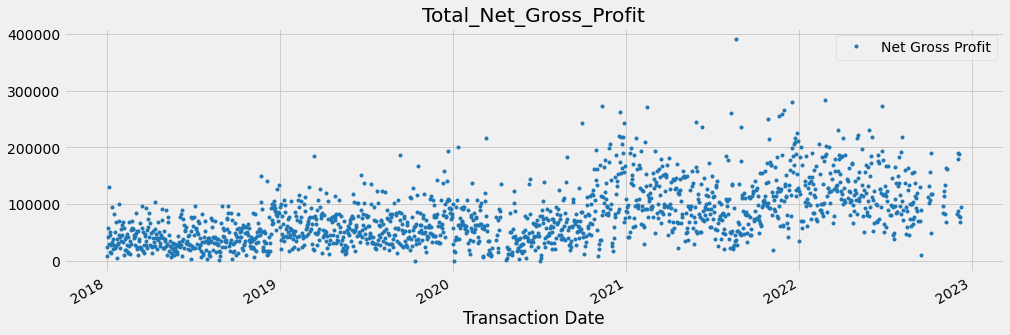

In [3]:
df.plot(style='.',
        figsize=(15, 5),
        color=color_pal[0],
        title='Total_Net_Gross_Profit')
plt.show()

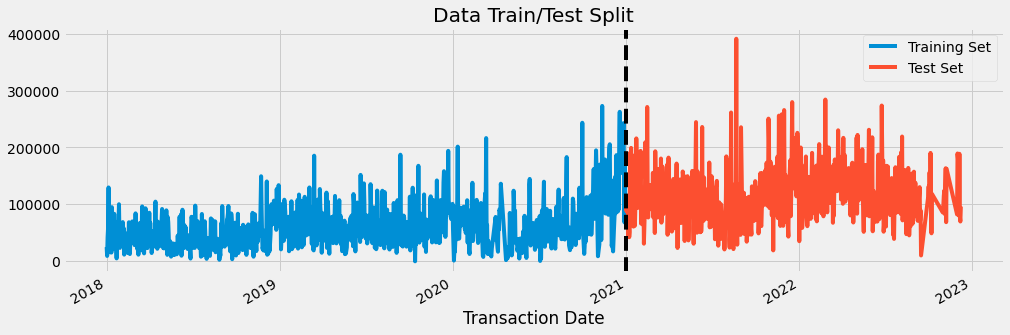

In [4]:
train = df.loc[df.index < '01-01-2021']
test = df.loc[df.index >= '01-01-2021']

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('01-01-2021', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

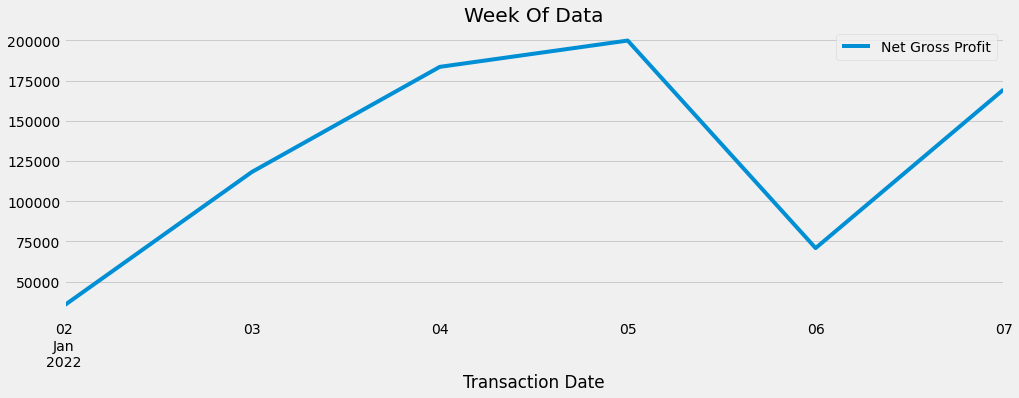

In [5]:
df.loc[(df.index > '01-01-2022') & (df.index < '01-08-2022')] \
    .plot(figsize=(15, 5), title='Week Of Data')
plt.show()

In [6]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df = create_features(df)

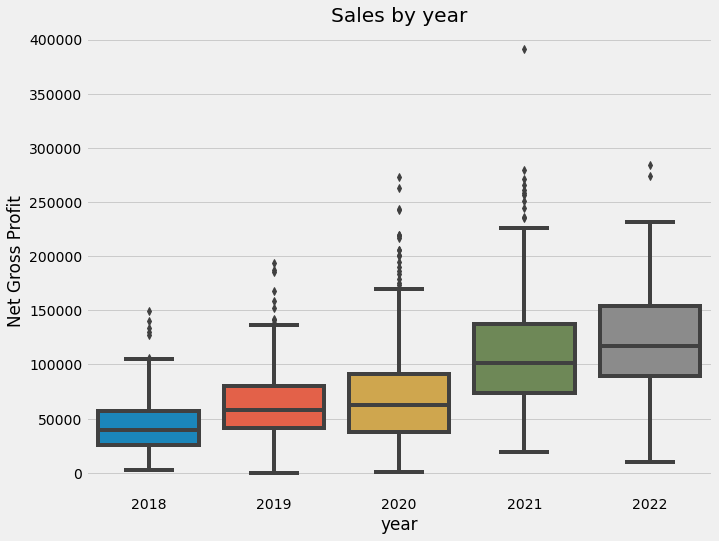

In [7]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='year', y='Net Gross Profit')
ax.set_title('Sales by year')
plt.show()

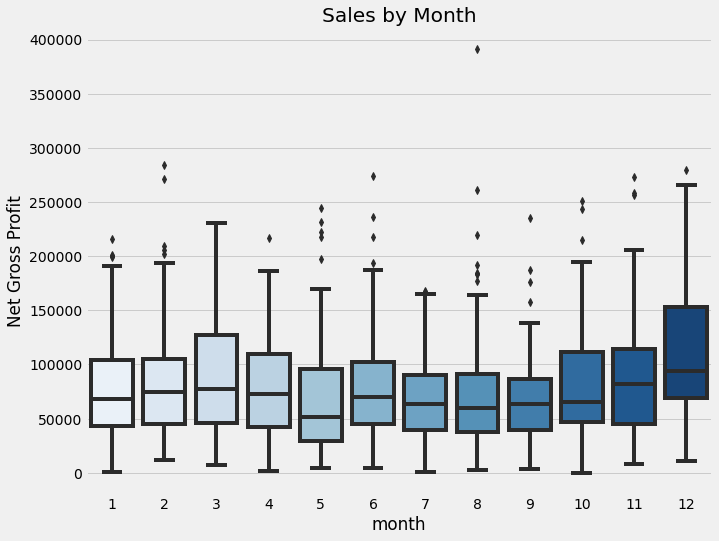

In [8]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='month', y='Net Gross Profit', palette='Blues')
ax.set_title('Sales by Month')
plt.show()

In [9]:
train = create_features(train)
test = create_features(test)

FEATURES = ['dayofyear', 'dayofweek', 'quarter', 'month', 'year']
TARGET = 'Net Gross Profit'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [ ]:
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

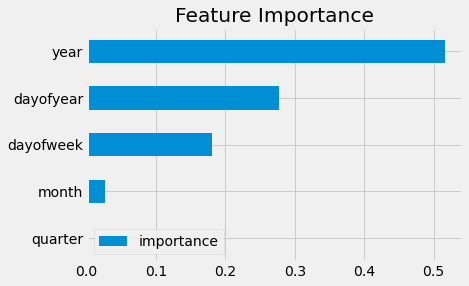

In [11]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

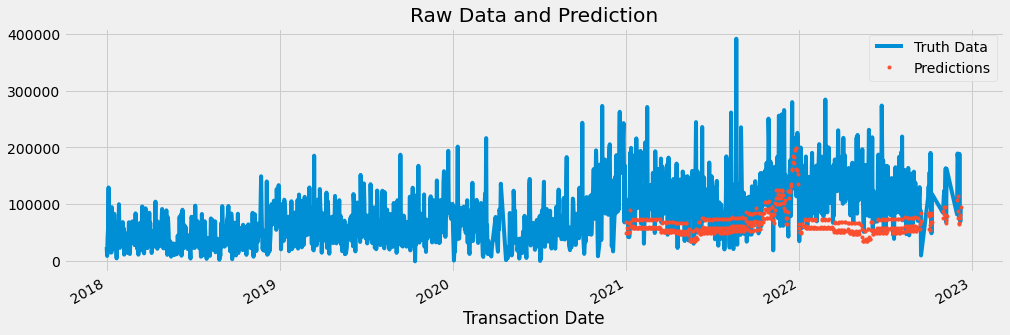

In [12]:
test['prediction'] = reg.predict(X_test)
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)
ax = df[['Net Gross Profit']].plot(figsize=(15, 5))
df['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Data and Prediction')
plt.show()

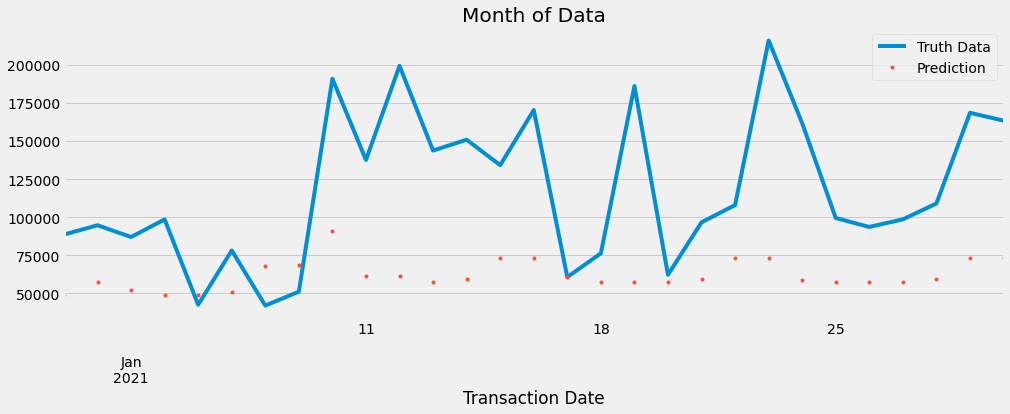

In [13]:


ax = df.loc[(df.index > '01-01-2021') & (df.index < '31-01-2021')]['Net Gross Profit'] \
    .plot(figsize=(15, 5), title='Month of Data')
df.loc[(df.index > '01-01-2021') & (df.index < '31-01-2021')]['prediction'] \
    .plot(style='.')
plt.legend(['Truth Data','Prediction'])
plt.show()



In [14]:
score = np.sqrt(mean_squared_error(test['Net Gross Profit'], test['prediction']))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 68609.48


In [15]:
test['error'] = np.abs(test[TARGET] - test['prediction'])
test['date'] = test.index.date
test.groupby(['date'])['error'].mean().sort_values(ascending=False).head(10)

date
2021-08-22    329548.269591
2021-02-15    213817.802133
2022-02-26    210967.199975
2021-08-11    203998.684615
2022-06-25    200178.209583
2022-05-29    188972.605968
2021-05-29    187950.144723
2021-09-01    178725.636471
2022-05-05    170727.004862
2022-05-03    168984.862069
Name: error, dtype: float64

<AxesSubplot:ylabel='Frequency'>

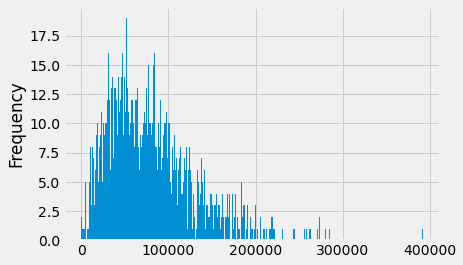

In [16]:
df['Net Gross Profit'].plot(kind='hist', bins=500)

In [17]:
from sklearn.model_selection import TimeSeriesSplit

tss = TimeSeriesSplit(n_splits=4, test_size=365*1, gap=1)
df = df.sort_index()



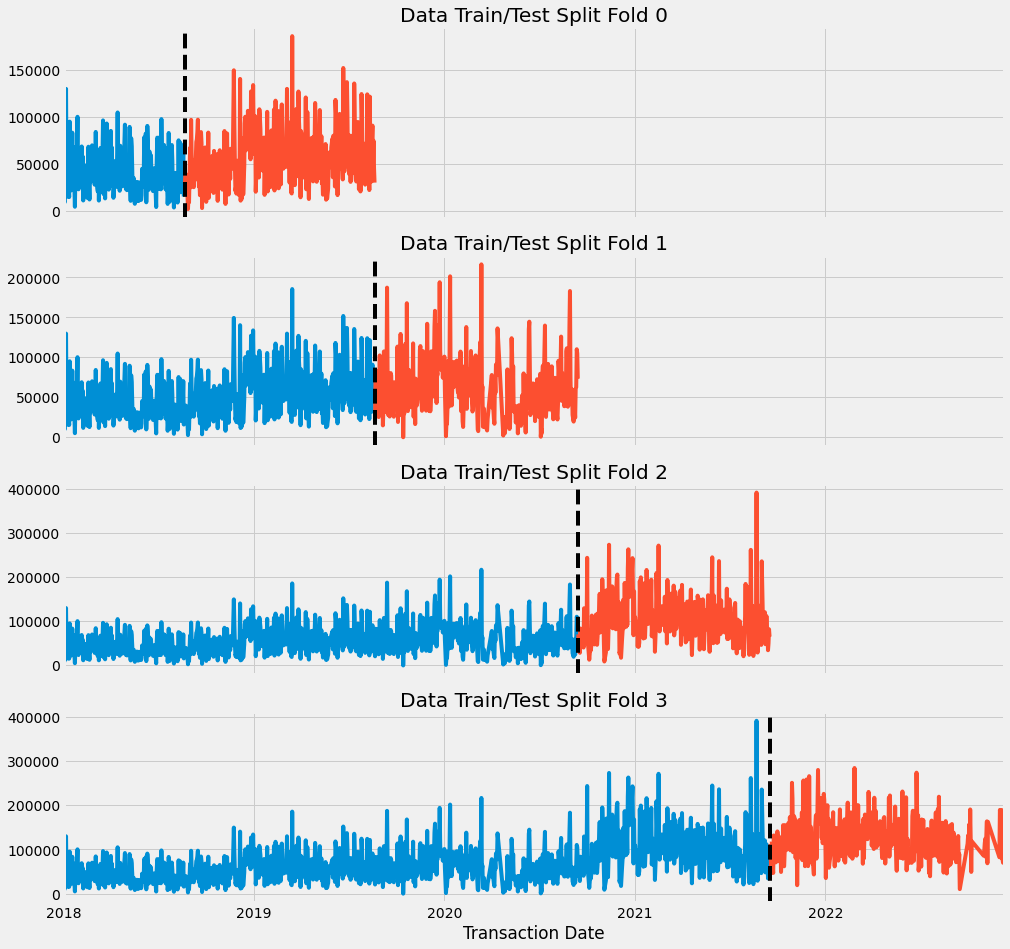

In [18]:
fig, axs = plt.subplots(4, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    train['Net Gross Profit'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}')
    test['Net Gross Profit'].plot(ax=axs[fold],
                         label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
plt.show()

In [19]:
def add_lags(df):
    target_map = df['Net Gross Profit'].to_dict()
    df['lag1'] = (df.index - pd.Timedelta('364 days')).map(target_map)
    df['lag2'] = (df.index - pd.Timedelta('546 days')).map(target_map)
    return df

In [20]:
df = add_lags(df)

In [ ]:
tss = TimeSeriesSplit(n_splits=4, test_size=365*1, gap=1)
df = df.sort_index()


fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    train = create_features(train)
    test = create_features(test)

    FEATURES = ['dayofyear', 'dayofweek', 'quarter', 'month','year',
                'lag1','lag2']
    TARGET = 'Net Gross Profit'

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                           n_estimators=1000,
                           early_stopping_rounds=50,
                           objective='reg:linear',
                           max_depth=3,
                           learning_rate=0.01)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

In [22]:
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')

Score across folds 47189.1310
Fold scores:[34991.85865312868, 34771.090640750466, 67956.14362237332, 51037.43105616336]


In [ ]:
df = create_features(df)

FEATURES = ['dayofyear', 'dayofweek', 'quarter', 'month', 'year',
            'lag1','lag2']
TARGET = 'Net Gross Profit'

X_all = df[FEATURES]
y_all = df[TARGET]

reg = xgb.XGBRegressor(base_score=0.5,
                       booster='gbtree',    
                       n_estimators=650,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_all, y_all,
        eval_set=[(X_all, y_all)],
        verbose=100)

In [24]:
df.index.max()

Timestamp('2022-12-09 00:00:00')

In [25]:
future = pd.date_range('2022-12-09','2023-12-09', freq='24h')
future_df = pd.DataFrame(index=future)
future_df['isFuture'] = True
df['isFuture'] = False
df_and_future = pd.concat([df, future_df])
df_and_future = create_features(df_and_future)
df_and_future = add_lags(df_and_future)

In [26]:
future_w_features = df_and_future.query('isFuture').copy()

In [27]:
future_w_features['pred'] = reg.predict(future_w_features[FEATURES])

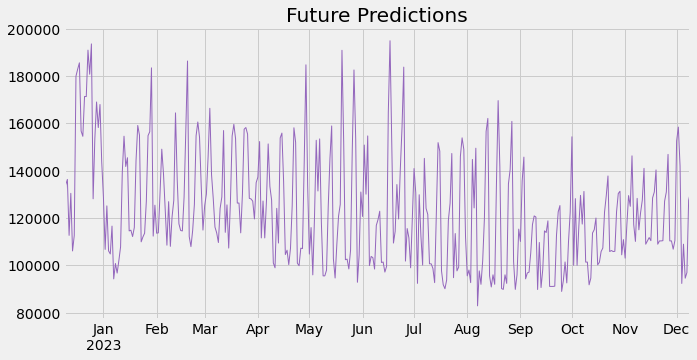

In [28]:
future_w_features['pred'].plot(figsize=(10, 5),
                               color=color_pal[4],
                               ms=1,
                               lw=1,
                               title='Future Predictions')
plt.show()

In [29]:
future_w_features

,Net Gross Profit,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,prediction,lag1,lag2,isFuture,pred
2022-12-09,NaN,4,4,12,2022,343,9,49,NaN,43077.289398,236006.635034,True,117050.406250
2022-12-10,NaN,5,4,12,2022,344,10,49,NaN,125878.877902,71762.756504,True,133902.421875
2022-12-11,NaN,6,4,12,2022,345,11,49,NaN,133282.689673,88460.216397,True,136240.609375
2022-12-12,NaN,0,4,12,2022,346,12,50,NaN,159825.283142,70956.576235,True,112602.140625
2022-12-13,NaN,1,4,12,2022,347,13,50,NaN,177371.722351,147114.229870,True,130360.125000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-05,NaN,1,4,12,2023,339,5,49,NaN,188853.071199,106689.576117,True,108875.898438
2023-12-06,NaN,2,4,12,2023,340,6,49,NaN,77839.483841,123201.354781,True,94508.539062
2023-12-07,NaN,3,4,12,2023,341,7,49,NaN,69690.230072,67872.949649,True,96893.648438
2023-12-08,NaN,4,4,12,2023,342,8,49,NaN,NaN,NaN,True,127410.984375


In [30]:
col1 = future_w_features['pred']
Prediction_df = pd.DataFrame({'Net Gross Profit': col1})

Prediction_df

,Net Gross Profit
2022-12-09,117050.406250
2022-12-10,133902.421875
2022-12-11,136240.609375
2022-12-12,112602.140625
2022-12-13,130360.125000
...,...
2023-12-05,108875.898438
2023-12-06,94508.539062
2023-12-07,96893.648438
2023-12-08,127410.984375


In [31]:
Historical_Pred_df = pd.concat([df, Prediction_df], axis=0)

In [32]:
Historical_Pred_df

,Net Gross Profit,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,prediction,lag1,lag2,isFuture
2018-01-01,24543.649847,0.0,1.0,1.0,2018.0,1.0,1.0,1,NaN,NaN,NaN,False
2018-01-02,9091.714241,1.0,1.0,1.0,2018.0,2.0,2.0,1,NaN,NaN,NaN,False
2018-01-03,41890.553555,2.0,1.0,1.0,2018.0,3.0,3.0,1,NaN,NaN,NaN,False
2018-01-04,58754.045576,3.0,1.0,1.0,2018.0,4.0,4.0,1,NaN,NaN,NaN,False
2018-01-05,129612.985417,4.0,1.0,1.0,2018.0,5.0,5.0,1,NaN,NaN,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-05,108875.898438,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,NaN,NaN,NaN,NaN
2023-12-06,94508.539062,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,NaN,NaN,NaN,NaN
2023-12-07,96893.648438,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,NaN,NaN,NaN,NaN
2023-12-08,127410.984375,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,NaN,NaN,NaN,NaN


In [33]:
Historical_Pred_df = Historical_Pred_df[['Net Gross Profit']]

In [34]:
Historical_Pred_df

,Net Gross Profit
2018-01-01,24543.649847
2018-01-02,9091.714241
2018-01-03,41890.553555
2018-01-04,58754.045576
2018-01-05,129612.985417
...,...
2023-12-05,108875.898438
2023-12-06,94508.539062
2023-12-07,96893.648438
2023-12-08,127410.984375


In [35]:
Historical_Pred_df.rename_axis("Transaction Date", axis=0, inplace=True)

In [36]:
Historical_Pred_df.to_csv('Mens_Historical_Pred_df_NetGrossProfit.csv', index=True)

In [37]:
df_Prediction = pd.read_csv('Mens_Historical_Pred_df_NetGrossProfit.csv')
df_Prediction = df_Prediction.set_index('Transaction Date')
df_Prediction.index = pd.to_datetime(df_Prediction.index)

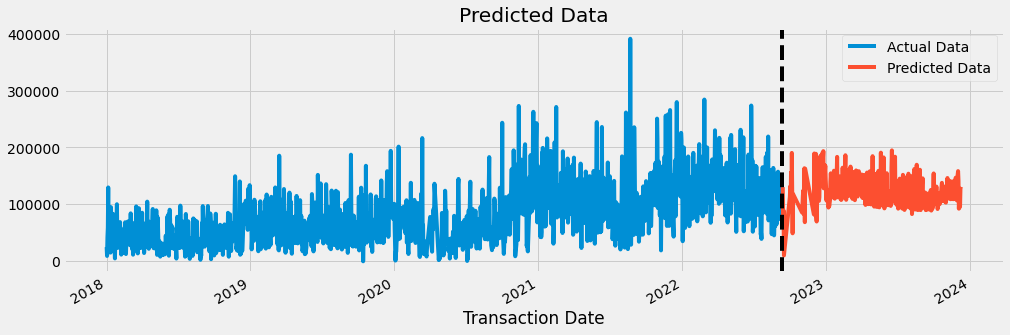

In [38]:
Actual = Historical_Pred_df.loc[df_Prediction.index < '09-12-2022']
Prediction = Historical_Pred_df.loc[df_Prediction.index >= '9-12-2022']

fig, ax = plt.subplots(figsize=(15, 5))
Actual.plot(ax=ax, label='Actual Data', title='Predicted Data')
Prediction.plot(ax=ax, label='Predicted Data')
ax.axvline('09-12-2022', color='black', ls='--')
ax.legend(['Actual Data', 'Predicted Data'])
plt.show()